In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix
stockList = ['AAPL', 'AMZN']
stocks = [stock + '' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  2 of 2 completed


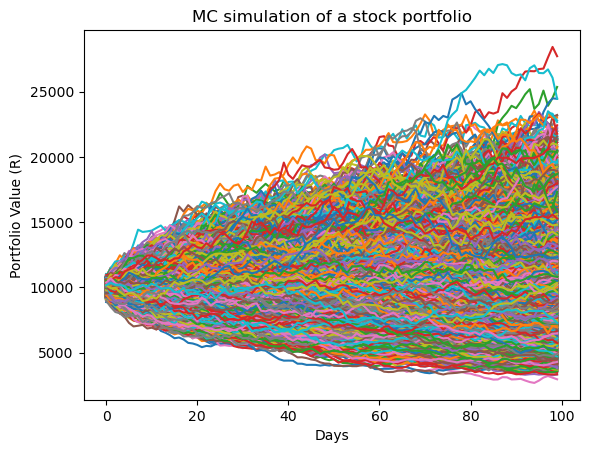

VaR = R4089.48
CVaR = R4652.92


In [2]:
# Monte Carlo Method
mc_sims = 100000 # number of simulations
T = 100 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (R)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
portResults = pd.Series(portfolio_sims[-1,:])
VaR = (initialPortfolio - mcVaR(portResults, alpha=5))
CVaR = (initialPortfolio - mcCVaR(portResults, alpha=5))
print('VaR = R{}'.format(round(VaR,2)))
print('CVaR = R{}'.format(round(CVaR,2)))